# Mapping the Latent Space of CXR Patient Geometry
## Zebrastack V0 VAE trained on the CovidNet chest radiograph dataset
The zebrastack is a variational auto-encoder that is _very_ roughly aligned with the distributed hierarchical architecture + shifter circuit.  Here it is applied to recognition of the CovidNet chest radiograph dataset.

First we load some center-surround processed images

Loaded 2564 npy in 1.1820018291473389 seconds


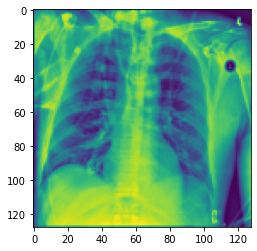

In [1]:
import numpy as np
# from common.image_preprocessing import temp_from_original
from pathlib import Path, PurePath
import time, os
import matplotlib.pyplot as plt

sz = 128
# cxr8_original_path = Path(os.environ['DATA_NIH_CXR8']) / 'by_class' / 'no_finding'
cxr8_temp = Path('G:\Data_Training_MedicalImaging\zebtrastack_temp') / 'chest-nihcc' / '128x128' / 'clahe_processed' # temp_from_original(cxr8_original_path, temp_relative_path)
processed_imgs = {}

start_time = time.time()
for npy_filepath in list(cxr8_temp.glob('*.npy'))[:20000]:
    img = np.load(npy_filepath)
    # print(img.shape)
    # img = np.reshape(img, (img.shape[],img.shape[1],4))
    processed_imgs[npy_filepath.stem] = img
    if len(processed_imgs) % 100 == 0:
        print(f"{npy_filepath.stem}: {img.shape} {np.max(img)}       ", end='\r')
        plt.imshow(img)
    if len(processed_imgs) > 30000:
        break
end_time = time.time()

print(f"Loaded {len(processed_imgs)} npy in {end_time - start_time} seconds")

Partition the data in to train and test: 90% train and 10% test.  We are assuming all images are from distinct patients, so there is no need to partition by subject.

In [2]:
test_count = int(len(processed_imgs)/10)
processed_img_list = list(processed_imgs.values())
x_test = processed_img_list[:test_count]
x_train = processed_img_list[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(f"Training data has shape {x_train.shape}")
print(f"Testing data has shape {x_test.shape}")

x_train = np.reshape(x_train, (x_train.shape[0], 128, 128, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 128, 128, 1))
print(f"Reshaped shape = {x_train.shape}")

Training data has shape (2308, 128, 128)
Testing data has shape (256, 128, 128)
Reshaped shape = (2308, 128, 128, 1)


In [3]:
# min_all = np.min(x_train,axis=(0,1,2))
# max_all = np.max(x_train,axis=(0,1,2))
# width_all = max_all - min_all
# print(min_all, max_all, width_all)

In [4]:
# x_train = (x_train - min_all) / width_all
# x_test = (x_test - min_all) / width_all

In [5]:
# re_min_all = np.min(x_train,axis=(0,1,2))
# re_max_all = np.max(x_train,axis=(0,1,2))
# re_width_all = re_max_all - re_min_all
# print(re_min_all, re_max_all, re_width_all)

## Defining the Variational Autoencoder
To defined the variational autoencoder, we need to helper functions:
* A function for reparameterized sampling
* A function for KLDiv loss

In [6]:
from cxr_projection.zebrastack_v0_model import create_autoencoder, create_encoder, create_decoder
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
# tf.compat.v1.disable_eager_execution()

In [7]:
retina, encoder, shape, [z_mean, z_log_var, z] = create_encoder()
decoder = create_decoder(shape)
autoencoder = create_autoencoder(retina, encoder, [z_mean, z_log_var, z], decoder)

Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 32) 832         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 32)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 32)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

## Pre-Training the model
Train by calling .fit with the training data.  
* Batch size of 512 helps convergence, but causes resource exhaustion > 128x128.
* Epochs > 1024 take a while, but tend to lead to better results

In [8]:
autoencoder.fit(x_train, x_train, epochs=32, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test))

Train on 2308 samples, validate on 256 samples
Epoch 1/32
2308/2308 [==============================] - ETA: 0s - loss: 0.1243

e:\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2308/2308 [==============================] - 10s 4ms/sample - loss: 0.1243 - val_loss: 0.1187
Epoch 2/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1203 - val_loss: 0.1150
Epoch 3/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1165 - val_loss: 0.1115
Epoch 4/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1129 - val_loss: 0.1084
Epoch 5/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1097 - val_loss: 0.1056
Epoch 6/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1068 - val_loss: 0.1031
Epoch 7/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1042 - val_loss: 0.1008
Epoch 8/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.1019 - val_loss: 0.0989
Epoch 9/32
2308/2308 [==============================] - 5s 2ms/sample - loss: 0.0998 - val_loss: 0.0971
Epoch 10/32
2308/2308 [==============================] - 5s 2ms/sample - l

## Inspecting Reconstructing Images
To qualitatively assess the model, look at a few images and their reconstructions from latent vectors

In [9]:
from functools import lru_cache
import numpy as np

# @lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

In [10]:
from cxr_projection.show_original_decoded import show_grayscale, show_original_decoded

encode_only_imgs = encoder.predict(x_test[:10])
print(encode_only_imgs[2][0])
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
# show_original_decoded(x_test[:10], decoded_imgs, sz)

[ 0.90561646 -0.23259442 -0.4686767  -1.583285   -1.013171    1.210022
  0.04888432 -0.27043298]


In [11]:
decoded_imgs[0].shape

(1, 128, 128, 1)

[0. 0. 0. 0. 0. 0. 0. 0.]
[[[[0.62336105]
   [0.6382729 ]
   [0.6601628 ]
   ...
   [0.67929834]
   [0.6516269 ]
   [0.6591737 ]]

  [[0.5616617 ]
   [0.55919385]
   [0.5974861 ]
   ...
   [0.6428902 ]
   [0.65051395]
   [0.72488046]]

  [[0.5114743 ]
   [0.48407403]
   [0.4893725 ]
   ...
   [0.5426667 ]
   [0.5558332 ]
   [0.6635227 ]]

  ...

  [[0.52159196]
   [0.535851  ]
   [0.5319594 ]
   ...
   [0.48650616]
   [0.51068527]
   [0.62870187]]

  [[0.4275222 ]
   [0.40395784]
   [0.44242156]
   ...
   [0.40851513]
   [0.4364346 ]
   [0.5464276 ]]

  [[0.44461894]
   [0.4035116 ]
   [0.43151745]
   ...
   [0.41571778]
   [0.4199995 ]
   [0.51086086]]]]


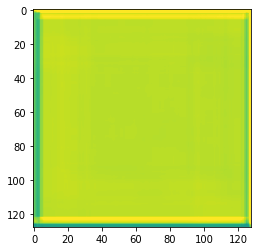

In [13]:
all_z = np.zeros(8)
print(all_z)
decoded = decoder.predict([[all_z]])
print(decoded)
plt.imshow(np.reshape(decoded,(128,128)), vmin=0.2, vmax=0.6)

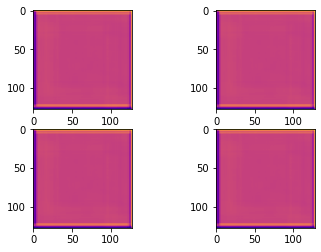

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2)
for n in range(4):
    level_img = np.reshape(decoded_imgs[0], (128,128))
    axs[n // 2][n % 2].imshow(level_img, cmap='plasma') # , vmin=-.5, vmax=.5)

In [ ]:
from common.filter_banks import make_gauss_kernels, make_dog_kernels, show_filter_bank
dog_kernels_tf = make_dog_kernels()
show_filter_bank(dog_kernels_tf)

In [ ]:
#min_all = [-0.3100704,  -0.23559849, -0.02646105,  0.        ] 
# max_all = [0.42579,    0.38077682, 0.44011822, 0.54857194]
#width_all = [0.7358604,  0.6163753,  0.46657926, 0.54857194]

re_decoded_img = decoded_imgs[6]
re_decoded_img = width_all * re_decoded_img + min_all
# print(decoded_imgs[6])
print(re_decoded_img)

In [ ]:
%matplotlib notebook
import tensorflow as tf
def mse_tf(current_tf:tf.Tensor, kernel_tf:tf.Tensor, match_tf:tf.Tensor):
    current_out_tf = \
        tf.nn.conv2d(current_tf, kernel_tf,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    loss = tf.reduce_mean((current_out_tf - match_tf) ** 2)
    return loss

sz = 128
current_value = tf.Variable(np.zeros((1,sz,sz,1)), dtype=tf.float32)
with tf.GradientTape() as tape:
    current_out = mse_tf(current_value, dog_kernels_tf, re_decoded_img)
grad = tape.gradient(current_out, current_value)

fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1,2,figsize=(5,3))
learning_rate = 1e+3
for n in range(100):
    current_value.assign_sub(learning_rate * grad)
    with tf.GradientTape() as tape:
        current_out = mse_tf(current_value, dog_kernels_tf, re_decoded_img)
        print(f"loss = {current_out}   ", end='\r')
    grad = tape.gradient(current_out, current_value)
axs[0].imshow(tf.reshape(current_value, (sz,sz)), cmap='gray')
axs[1].imshow(tf.reshape(grad, (sz,sz)))
plt.show()

OK? so then save the model

In [ ]:
from datetime import datetime
from common.image_preprocessing import data_all, data_temp

weights_cxr8_temp = temp_from_original(cxr8_original_path, PurePath(f"{sz}x{sz}") / 'weights')
timestamp = datetime.now().strftime("%Y%m%d%H%M")
print("Saving ", weights_cxr8_temp / f"{timestamp}_rgc_encoder.h5")
encoder.save_weights(weights_cxr8_temp / f"{timestamp}_rgc_encoder.h5")
print("Saving ", weights_cxr8_temp / f"{timestamp}_rgc_decoder.h5")
decoder.save_weights(weights_cxr8_temp / f"{timestamp}_rgc_decoder.h5")
print("Saving ", weights_cxr8_temp / f"{timestamp}_rgc_autoencoder.h5")
autoencoder.save_weights(weights_cxr8_temp / f"{timestamp}_rgc_autoencoder.h5")

In [ ]:
shift_processed_path = "E:\\Data\\anat0mixer_temp\\shifter_processed"
for n in range(len(x_train_shifted)):
    np.save(shift_processed_path+f"\\x_train_shifted_{n}", 
            x_train_shifted[n])

In [ ]:
for n in range(len(x_test_shifted)):    
    np.save(shift_processed_path+f"\\x_test_shifted_{n}", 
            x_test_shifted[n])

In [ ]:
from pathlib import Path
x_train_fns = \
    Path('E:\\Data\\anat0mixer_temp\\shifter_processed') \
        .glob('x_train_shifted_*.npy')
x_train_shifted = []
for fn in x_train_fns:
    x_train_shifted.append(np.load(fn))

x_test_fns = \
    Path('E:\\Data\\anat0mixer_temp\\shifter_processed') \
        .glob('x_test_shifted_*.npy')
x_test_shifted = []
for fn in x_test_fns:
    x_test_shifted.append(np.load(fn))

In [ ]:
x_train_shifted = np.array(x_train_shifted)
x_test_shifted = np.array(x_test_shifted)
x_train_shifted.shape, x_test_shifted.shape

In [ ]:
autoencoder.fit(x_train_shifted, x_train_shifted, 
                epochs=256, batch_size=128, 
                shuffle=True, validation_data=(x_test_shifted, x_test_shifted))

In [ ]:
import tensorflow as tf
autoencoder.save_weights('E:\\Data\\anat0mixer_temp\\autoencoder_v1')
encoder.save_weights('E:\\Data\\anat0mixer_temp\\encoder_v1')
decoder.save_weights('E:\\Data\\anat0mixer_temp\\decoder_v1')

In [ ]:
encoded_shift = encoder.predict(x_test_shifted[80:90])
decoded_imgs_shift = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encoded_shift[2]]
show_original_decoded(x_test_shifted[80:90], decoded_imgs_shift, sz)

## Saving the Model
If the model output looks good, then save it for subsequent use

In [ ]:
encoder.save('data\zebrastack_v0_covidnet_encoder_model')
decoder.save('data\zebrastack_v0_covidnet_decoder_model')

## Anat0Mixer Interaction

In [ ]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decoder, tuple(kwargs.values()))
    interp_array = decoded_pixel_array.reshape(sz,sz)
    # interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=0)
    # interp_array = interp_array.reshape(sz*4, sz*4)
    # ax.imshow(interp_array, cmap='gray')
    # a=im.get_array()    
    im.set_array(interp_array)
    fig.canvas.draw()
    return kwargs['1']

In [ ]:
%matplotlib notebook
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}

for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

decoded_pixel_array = decode_latent(decoder, tuple([slider.value for slider in kwargs.values()]))
interp_array = decoded_pixel_array.reshape(sz,sz)


In [ ]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
im = ax.imshow(interp_array, cmap='gray')

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'

import gc
gc.disable()
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)

In [ ]:
gc.enable()